In [1]:
# import libraries
import jax
import jax.numpy as jnp
try:
  import distrax
except ModuleNotFoundError:
  %pip install -qq distrax
  import distrax
try:
  import optax
except ModuleNotFoundError:
  %pip install -qq optax
  import optax
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import logging
import pickle
import scipy.stats as stats
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

2022-06-02 11:06:53.679759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
with open("../data/linear_regression_normal_distribution",'rb') as f:
    data = pickle.load(f)
data

{'data': {'x': array([[-1.4144772 ],
         [ 1.6039085 ],
         [ 2.293806  ],
         [ 3.8276772 ],
         [ 1.999692  ],
         [ 1.0609426 ],
         [ 1.2900534 ],
         [-2.3558607 ],
         [ 3.0193057 ],
         [-0.89879274]], dtype=float32),
  'y': array([ 1.2143412,  7.422146 , 10.44427  , 12.321105 ,  7.133485 ,
          6.848776 ,  6.8407617, -1.5791223, 11.820506 ,  1.6998756],
        dtype=float32)},
 'noise_variance': 1,
 'prior': {'mean': array([14. ,  7.3], dtype=float32),
  'var': array([[10.,  0.],
         [ 0., 10.]], dtype=float32)}}

In [3]:
x = jnp.array(data['data']['x'])

def identity_trans(x):
    return jnp.append(jnp.ones((m,1)),x,axis=1)
m = x.shape[0]
x_trans = identity_trans(x)
y = jnp.array(data['data']['y'])

prior_mean = jnp.array(data['prior']['mean'])
prior_var = jnp.array(data['prior']['var'])
noise_var = data['noise_variance']

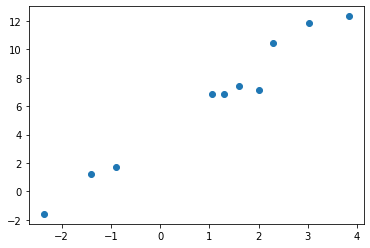

In [4]:
plt.scatter(x,y)

In [5]:
n = x_trans.shape[1]
prior_normal = tfd.MultivariateNormalFullCovariance(
    loc = prior_mean,covariance_matrix= prior_var
)
print(prior_normal.prob([2.1,2.2]))

3.6475258e-06


In [6]:
y = y.reshape(m,)
def neg_log_postfn(theta):
  log_prior = prior_normal.log_prob(theta)
  # log_likelihood
  mean = (x_trans@theta.reshape(n,1)).reshape(m,)
  likelihood_student = tfd.Normal(mean,1)
  log_like = jnp.array(jnp.sum(likelihood_student.log_prob(y)))
  return -(log_like+log_prior)


theta = jnp.array([10.3,11.2])
neg_log_postfn(theta)

DeviceArray(2647.8542, dtype=float32)

In [7]:
# automatic differenciation for finding the mode of the posterior.

def fit(params,optimizer,steps):
  opt_state = optimizer.init(params)

  @jax.jit
  def step(params,opt_state):
    loss_value, grads = jax.value_and_grad(neg_log_postfn)(params)
    updates, opt_state = optimizer.update(grads,opt_state,params)
    params = optax.apply_updates(params,updates)
    return params, opt_state, loss_value
  loss = []
  for i in range(steps):
    params,opt_state,loss_value = step(params, opt_state)
    loss.append(loss_value)
  return params,loss


params = theta
optimizer = optax.adam(learning_rate= 1e-2)
theta_MAP,loss = fit(params,optimizer,steps = 6000)
print(f"MAP found by automatic differenciation is {(theta_MAP)}")

MAP found by automatic differenciation is [4.1290503 2.2887053]


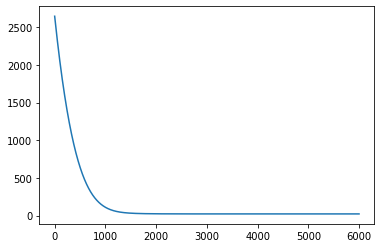

In [8]:
plt.plot(loss,label='loss')

In [9]:
hessian = (jax.hessian(neg_log_postfn)(theta_MAP))
# hessian = jnp.array([[hessian_dict['0']['0'],hessian_dict['0']['1']],[hessian_dict['1']['0'],hessian_dict['1']['1']]])
hessian

DeviceArray([[10.1     , 10.426254],
             [10.426254, 46.848644]], dtype=float32)

[4.1290503 2.2887053]


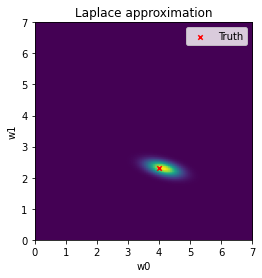

In [10]:
def plot_posterior(mean, cov, w0, w1,title=None,rang=(0,20)):
    resolution = 100

    grid_x = grid_y = jnp.linspace(rang[0], rang[1], resolution)
    grid_flat = jnp.dstack(jnp.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(rang[0], rang[1], rang[0], rang[1]))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')
    plt.legend()
    plt.title(title)
    plt.xlabel('w0')
    plt.ylabel('w1')

print(theta_MAP)
plot_posterior(theta_MAP, jnp.linalg.inv(hessian), 4.0, 2.3,title = "Laplace approximation",rang=(0,7))
plt.savefig("lin_reg_laplace_approx.png")

[4.129071  2.2886965]


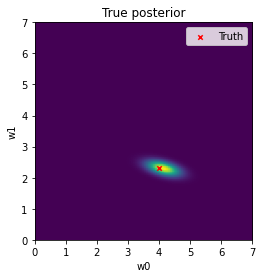

In [11]:
def posterior(phi,m_0, t, S_0, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = jnp.linalg.inv(S_0) + beta * phi.T.dot(phi)
    S_N = jnp.linalg.inv(S_N_inv)
    m_N =S_N@(jnp.linalg.inv(S_0)@m_0+beta *phi.T.dot(t))

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

m_N, S_N = posterior(phi=x_trans,m_0=prior_mean,t=y,S_0=prior_var,beta=1)
print(m_N.ravel())
plot_posterior(mean=m_N,cov=S_N,w0=4.0,w1=2.3,title="True posterior",rang=(0,7))
plt.savefig("true_posterior.png")

[14.   7.3]


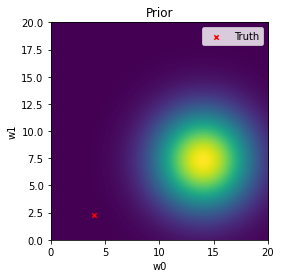

In [12]:
plot_posterior(mean=prior_mean,cov=prior_var,w0=4.0,w1=2.3,title="Prior")
plt.savefig("prior.png")
print(prior_mean)